In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install efficientnet_pytorch
!pip install tqdm
!pip install wandb

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=7fb8bec5545a5503e50c7b1440d1f80fd54cdcd3946b836ec

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pandas as pd
from PIL import Image
import os


In [ ]:
class RetinalDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx]['ID']
        img_path = os.path.join(self.root_dir, f"{img_id}.png")
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx]['Disease_Risk']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32), img_id  # <<< Return img_id too


In [ ]:

transform = transforms.Compose([
    transforms.Resize((380, 380)),  # EfficientNet B4 input size is 380x380
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Load datasets
train_dataset = RetinalDataset(
    csv_file='/content/drive/MyDrive/eye_dataset/Training_Set/normalities_prob.csv',
    root_dir='/content/drive/MyDrive/eye_dataset/Training_Set/Training',
    transform=transform
)

val_dataset = RetinalDataset(
    csv_file='/content/drive/MyDrive/eye_dataset/Evaluation_Set/normalities_prob_val.csv',
    root_dir='/content/drive/MyDrive/eye_dataset/Evaluation_Set/Validation',
    transform=transform
)

test_dataset=RetinalDataset(
    csv_file='/content/drive/MyDrive/eye_dataset/Test_Set/normalities_prob.csv',
    root_dir='/content/drive/MyDrive/eye_dataset/Test_Set/Test',
    transform=transform

)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

print("Dataloader size \n")


print(len(train_loader));
print(len(val_loader));
print(len(test_loader))

1920
640
640
Dataloader size 

120
40
40


In [ ]:
#Creating the subset from the val_loader

import torch
from torch.utils.data import DataLoader,Subset

indices= list(range(160));

val_subset_dataset= Subset(val_dataset,indices);

val_subset_loader=DataLoader(val_subset_dataset,batch_size=16,shuffle=False,num_workers=2)




In [ ]:
print(len(val_subset_dataset));
print(len(val_subset_loader))

160
10


In [ ]:
# Load EfficientNet B2
model = EfficientNet.from_pretrained('efficientnet-b4')

# Modify the final fully connected layer
model._fc = nn.Linear(model._fc.in_features, 1)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:01<00:00, 68.9MB/s]


Loaded pretrained weights for efficientnet-b4


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device",device);

device cuda


In [ ]:
model=model.to(device);
criterion = nn.BCEWithLogitsLoss()  # because we have 1 output node
optimizer = optim.Adam(model.parameters(), lr=0.0001)



In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jeevan-neupane002 (jeevan-neupane002-nepal-applied-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
train_dataset_len=len(train_dataset);
val_dataset_len=len(val_dataset);
val_subset_dataset_len=len(val_subset_dataset);

print("train_dataset_len ",train_dataset_len);
print("val_dataset_len ",val_dataset_len);
print("val_subset_dataset_len ",val_subset_dataset_len);

train_dataset_len  1920
val_dataset_len  640
val_subset_dataset_len  160


In [ ]:
import torch
import wandb
from tqdm import tqdm

# --- Initialize wandb ---
wandb.init(project="Eye_Disease_Pred_b4")

# --- Hyperparameters ---
num_epochs = 100
validation_interval_batches = 20  # Validate on val_subset_loader every 20 batches
early_stopping_patience = 5
early_stopping_delta = 0.001

# Trackers
best_val_accuracy = 0.0
early_stopping_counter = 0

# --- Dataset lengths (you must define these) ---
train_dataset_len = len(train_dataset)
val_dataset_len = len(val_dataset)
val_subset_dataset_len = len(val_subset_dataset)

# --- Helper Functions ---
def train_one_epoch(model, train_loader, val_subset_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Training", ncols=100)

    for batch_idx, (batch_idx_data) in train_loader_tqdm:
        inputs, labels = batch_idx_data[0], batch_idx_data[1]
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels.bool()).sum().item()
        total += batch_size

        # Log batch-wise training metrics
        wandb.log({
            "train/loss_batch": loss.item(),
            "train/accuracy_batch": correct / total
        }, step=epoch * len(train_loader) + batch_idx)

        train_loader_tqdm.set_postfix(loss=loss.item())

        # Validate on val_subset_loader every fixed number of batches
        if (batch_idx + 1) % validation_interval_batches == 0:
            val_subset_loss, val_subset_acc = validate(model, val_subset_loader, criterion, device, dataset_len=val_subset_dataset_len, subset=True)
            wandb.log({
                "val_subset/loss": val_subset_loss,
                "val_subset/accuracy": val_subset_acc
            }, step=epoch * len(train_loader) + batch_idx)
            print(f"🔎 Validation on val_subset after {batch_idx+1} batches: Loss={val_subset_loss:.4f} Acc={val_subset_acc:.4f}")

    avg_loss = running_loss / train_dataset_len
    avg_acc = correct / total
    return avg_loss, avg_acc


def validate(model, loader, criterion, device, dataset_len, subset=False):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    desc = "Validation Subset" if subset else "Validation Full"
    val_loader_tqdm = tqdm(loader, desc=desc, leave=False, ncols=100)

    with torch.no_grad():
        for batch_data in val_loader_tqdm:
            inputs, labels = batch_data[0], batch_data[1]  # Correct unpacking
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            batch_size = inputs.size(0)
            val_loss += loss.item() * batch_size

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += batch_size

    avg_loss = val_loss / dataset_len
    avg_acc = correct / total
    return avg_loss, avg_acc


def check_early_stopping(val_accuracy, best_val_accuracy, early_stopping_counter):
    if val_accuracy > best_val_accuracy + early_stopping_delta:
        best_val_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    return best_val_accuracy, early_stopping_counter


def save_best_model(model, path="/content/drive/MyDrive/eye_dataset/bestmodel/best_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"✅ Best model saved to {path}")


# --- Training Loop ---
for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, val_subset_loader, optimizer, criterion, device, epoch)

    # Log epoch-wise training metrics
    wandb.log({
        "train/loss_epoch": train_loss,
        "train/accuracy_epoch": train_acc
    }, step=(epoch+1) * len(train_loader))

    # Validate on full val_loader after epoch
    val_loss, val_accuracy = validate(model, val_loader, criterion, device, dataset_len=val_dataset_len, subset=False)

    wandb.log({
        "val/loss_epoch": val_loss,
        "val/accuracy_epoch": val_accuracy
    }, step=(epoch+1) * len(train_loader))

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Early stopping and save best model
    if val_accuracy > best_val_accuracy:
        save_best_model(model)
    best_val_accuracy, early_stopping_counter = check_early_stopping(val_accuracy, best_val_accuracy, early_stopping_counter)

    if early_stopping_counter >= early_stopping_patience:
        print(f"⏹ Early stopping triggered at epoch {epoch+1}.")
        break

# Finish wandb
wandb.finish()


Epoch 1 Training:  17%|█████▎                          | 20/120 [03:24<46:31, 27.91s/it, loss=0.532]

🔎 Validation on val_subset after 20 batches: Loss=0.5299 Acc=0.9625


Epoch 1 Training:  33%|██████████▋                     | 40/120 [05:13<12:45,  9.57s/it, loss=0.534]

🔎 Validation on val_subset after 40 batches: Loss=0.1740 Acc=0.9437


Epoch 1 Training:  50%|████████████████                | 60/120 [07:15<10:25, 10.43s/it, loss=0.301]

🔎 Validation on val_subset after 60 batches: Loss=0.4528 Acc=0.7000


Epoch 1 Training:  67%|█████████████████████▎          | 80/120 [09:11<07:27, 11.18s/it, loss=0.169]

🔎 Validation on val_subset after 80 batches: Loss=0.1907 Acc=0.9062


Epoch 1 Training:  83%|█████████████████████████▊     | 100/120 [11:07<03:31, 10.56s/it, loss=0.304]

🔎 Validation on val_subset after 100 batches: Loss=0.2032 Acc=0.8688


Epoch 1 Training: 100%|███████████████████████████████| 120/120 [12:54<00:00,  6.45s/it, loss=0.248]


🔎 Validation on val_subset after 120 batches: Loss=0.1302 Acc=0.9625


Epoch 1 | Train Loss: 0.3636 | Train Acc: 0.8375 | Val Loss: 0.2613 | Val Acc: 0.8594
✅ Best model saved to /content/drive/MyDrive/eye_dataset/bestmodel/best_model.pth


Epoch 2 Training:  17%|█████▎                          | 20/120 [01:03<12:43,  7.64s/it, loss=0.445]

🔎 Validation on val_subset after 20 batches: Loss=0.1392 Acc=0.9625


Epoch 2 Training:  33%|██████████▋                     | 40/120 [02:01<10:43,  8.04s/it, loss=0.151]

🔎 Validation on val_subset after 40 batches: Loss=0.1727 Acc=0.9000


Epoch 2 Training:  50%|████████████████                | 60/120 [02:57<07:40,  7.68s/it, loss=0.267]

🔎 Validation on val_subset after 60 batches: Loss=0.1393 Acc=0.9375


Epoch 2 Training:  67%|█████████████████████▎          | 80/120 [03:55<05:33,  8.34s/it, loss=0.575]

🔎 Validation on val_subset after 80 batches: Loss=0.1331 Acc=0.9313


Epoch 2 Training:  83%|█████████████████████████▊     | 100/120 [04:55<02:41,  8.08s/it, loss=0.367]

🔎 Validation on val_subset after 100 batches: Loss=0.1155 Acc=0.9375


Epoch 2 Training: 100%|███████████████████████████████| 120/120 [05:46<00:00,  2.89s/it, loss=0.306]


🔎 Validation on val_subset after 120 batches: Loss=0.1835 Acc=0.8875


Epoch 2 | Train Loss: 0.2660 | Train Acc: 0.8714 | Val Loss: 0.2699 | Val Acc: 0.8812
✅ Best model saved to /content/drive/MyDrive/eye_dataset/bestmodel/best_model.pth


Epoch 3 Training:  17%|█████▎                          | 20/120 [01:09<13:03,  7.83s/it, loss=0.216]

🔎 Validation on val_subset after 20 batches: Loss=0.2267 Acc=0.8875


Epoch 3 Training:  33%|██████████▋                     | 40/120 [02:06<11:00,  8.26s/it, loss=0.691]

🔎 Validation on val_subset after 40 batches: Loss=0.2540 Acc=0.8875


Epoch 3 Training:  50%|████████████████▌                | 60/120 [03:01<08:01,  8.02s/it, loss=0.18]

🔎 Validation on val_subset after 60 batches: Loss=0.1845 Acc=0.9250


Epoch 3 Training:  67%|█████████████████████▎          | 80/120 [04:00<05:17,  7.93s/it, loss=0.127]

🔎 Validation on val_subset after 80 batches: Loss=0.2454 Acc=0.8875


Epoch 3 Training:  83%|█████████████████████████▊     | 100/120 [04:58<02:24,  7.25s/it, loss=0.416]

🔎 Validation on val_subset after 100 batches: Loss=0.2452 Acc=0.8812


Epoch 3 Training: 100%|███████████████████████████████| 120/120 [05:46<00:00,  2.89s/it, loss=0.147]


🔎 Validation on val_subset after 120 batches: Loss=0.2340 Acc=0.8688


Epoch 3 | Train Loss: 0.1975 | Train Acc: 0.9161 | Val Loss: 0.2790 | Val Acc: 0.8609


Epoch 4 Training:  17%|█████▎                          | 20/120 [01:03<12:55,  7.75s/it, loss=0.308]

🔎 Validation on val_subset after 20 batches: Loss=0.3391 Acc=0.8125


Epoch 4 Training:  33%|██████████▎                    | 40/120 [02:02<10:25,  7.82s/it, loss=0.0637]

🔎 Validation on val_subset after 40 batches: Loss=0.2306 Acc=0.9062


Epoch 4 Training:  50%|███████████████▌               | 60/120 [03:01<07:56,  7.94s/it, loss=0.0482]

🔎 Validation on val_subset after 60 batches: Loss=0.2323 Acc=0.9062


Epoch 4 Training:  67%|████████████████████▋          | 80/120 [03:58<04:58,  7.45s/it, loss=0.0707]

🔎 Validation on val_subset after 80 batches: Loss=0.1978 Acc=0.9563


Epoch 4 Training:  83%|█████████████████████████▊     | 100/120 [04:54<02:38,  7.93s/it, loss=0.288]

🔎 Validation on val_subset after 100 batches: Loss=0.2299 Acc=0.9000


Epoch 4 Training: 100%|██████████████████████████████| 120/120 [05:45<00:00,  2.88s/it, loss=0.0375]


🔎 Validation on val_subset after 120 batches: Loss=0.2425 Acc=0.8938


Epoch 4 | Train Loss: 0.1403 | Train Acc: 0.9432 | Val Loss: 0.2885 | Val Acc: 0.8875
✅ Best model saved to /content/drive/MyDrive/eye_dataset/bestmodel/best_model.pth


Epoch 5 Training:  17%|█████▎                          | 20/120 [01:07<13:40,  8.20s/it, loss=0.398]

🔎 Validation on val_subset after 20 batches: Loss=0.7757 Acc=0.7188


Epoch 5 Training:  33%|██████████▋                     | 40/120 [02:04<10:50,  8.13s/it, loss=0.113]

🔎 Validation on val_subset after 40 batches: Loss=0.2075 Acc=0.9000


Epoch 5 Training:  50%|███████████████               | 60/120 [03:00<07:11,  7.20s/it, loss=0.00694]

🔎 Validation on val_subset after 60 batches: Loss=0.2415 Acc=0.9062


Epoch 5 Training:  67%|████████████████████▋          | 80/120 [03:58<05:12,  7.82s/it, loss=0.0955]

🔎 Validation on val_subset after 80 batches: Loss=0.2425 Acc=0.9125


Epoch 5 Training:  83%|█████████████████████████     | 100/120 [04:53<02:29,  7.49s/it, loss=0.0633]

🔎 Validation on val_subset after 100 batches: Loss=0.2083 Acc=0.9375


Epoch 5 Training: 100%|██████████████████████████████| 120/120 [05:50<00:00,  2.92s/it, loss=0.0198]


🔎 Validation on val_subset after 120 batches: Loss=0.2526 Acc=0.9187


Epoch 5 | Train Loss: 0.1001 | Train Acc: 0.9682 | Val Loss: 0.3704 | Val Acc: 0.8812


Epoch 6 Training:  17%|█████▎                          | 20/120 [01:07<13:49,  8.30s/it, loss=0.161]

🔎 Validation on val_subset after 20 batches: Loss=0.4805 Acc=0.8375


Epoch 6 Training:  33%|██████████▎                    | 40/120 [02:04<10:34,  7.93s/it, loss=0.0812]

🔎 Validation on val_subset after 40 batches: Loss=0.3002 Acc=0.8938


Epoch 6 Training:  50%|███████████████▌               | 60/120 [02:58<07:18,  7.30s/it, loss=0.0153]

🔎 Validation on val_subset after 60 batches: Loss=0.2190 Acc=0.9437


Epoch 6 Training:  67%|████████████████████          | 80/120 [03:57<05:15,  7.88s/it, loss=0.00192]

🔎 Validation on val_subset after 80 batches: Loss=0.3288 Acc=0.9125


Epoch 6 Training:  83%|█████████████████████████     | 100/120 [04:54<02:35,  7.79s/it, loss=0.0135]

🔎 Validation on val_subset after 100 batches: Loss=0.2608 Acc=0.9375


Epoch 6 Training: 100%|█████████████████████████████| 120/120 [05:45<00:00,  2.88s/it, loss=0.00376]


🔎 Validation on val_subset after 120 batches: Loss=0.3157 Acc=0.9250


Epoch 6 | Train Loss: 0.0649 | Train Acc: 0.9766 | Val Loss: 0.5641 | Val Acc: 0.8766


Epoch 7 Training:  17%|█████▎                          | 20/120 [01:08<13:34,  8.14s/it, loss=0.112]

🔎 Validation on val_subset after 20 batches: Loss=0.3744 Acc=0.9187


Epoch 7 Training:  33%|██████████                    | 40/120 [02:05<10:49,  8.11s/it, loss=0.00865]

🔎 Validation on val_subset after 40 batches: Loss=0.4088 Acc=0.9062


Epoch 7 Training:  50%|██████████████▌              | 60/120 [03:03<08:07,  8.12s/it, loss=0.000615]

🔎 Validation on val_subset after 60 batches: Loss=0.3056 Acc=0.9250


Epoch 7 Training:  67%|███████████████████▎         | 80/120 [04:00<04:56,  7.42s/it, loss=0.000418]

🔎 Validation on val_subset after 80 batches: Loss=0.3795 Acc=0.9062


Epoch 7 Training:  83%|████████████████████████▏    | 100/120 [04:55<02:32,  7.63s/it, loss=0.00346]

🔎 Validation on val_subset after 100 batches: Loss=0.2617 Acc=0.9313


Epoch 7 Training: 100%|█████████████████████████████| 120/120 [05:44<00:00,  2.87s/it, loss=0.00878]


🔎 Validation on val_subset after 120 batches: Loss=0.3057 Acc=0.9187


Epoch 7 | Train Loss: 0.0324 | Train Acc: 0.9917 | Val Loss: 0.5217 | Val Acc: 0.8812


Epoch 8 Training:  17%|█████▌                           | 20/120 [01:07<14:02,  8.42s/it, loss=0.23]

🔎 Validation on val_subset after 20 batches: Loss=0.4230 Acc=0.8812


Epoch 8 Training:  33%|██████████▎                    | 40/120 [02:06<11:23,  8.54s/it, loss=0.0238]

🔎 Validation on val_subset after 40 batches: Loss=0.4549 Acc=0.8938


Epoch 8 Training:  50%|██████████████▌              | 60/120 [03:02<07:24,  7.40s/it, loss=0.000661]

🔎 Validation on val_subset after 60 batches: Loss=0.4664 Acc=0.8875


Epoch 8 Training:  67%|████████████████████▋          | 80/120 [03:56<05:09,  7.74s/it, loss=0.0434]

🔎 Validation on val_subset after 80 batches: Loss=0.1784 Acc=0.9500


Epoch 8 Training:  83%|████████████████████████▏    | 100/120 [04:54<02:36,  7.83s/it, loss=0.00398]

🔎 Validation on val_subset after 100 batches: Loss=0.2582 Acc=0.9187


Epoch 8 Training: 100%|██████████████████████████████| 120/120 [05:46<00:00,  2.89s/it, loss=0.0341]


🔎 Validation on val_subset after 120 batches: Loss=0.3480 Acc=0.9125


Epoch 8 | Train Loss: 0.0474 | Train Acc: 0.9812 | Val Loss: 0.5145 | Val Acc: 0.8750


Epoch 9 Training:  17%|█████▏                         | 20/120 [01:06<13:29,  8.09s/it, loss=0.0132]

🔎 Validation on val_subset after 20 batches: Loss=0.5437 Acc=0.8750


Epoch 9 Training:  33%|██████████                    | 40/120 [02:05<11:12,  8.40s/it, loss=0.00162]

🔎 Validation on val_subset after 40 batches: Loss=0.3693 Acc=0.9062


Epoch 9 Training:  50%|███████████████               | 60/120 [03:01<07:50,  7.84s/it, loss=0.00243]

🔎 Validation on val_subset after 60 batches: Loss=0.3291 Acc=0.9375


Epoch 9 Training:  67%|████████████████████          | 80/120 [03:57<05:11,  7.79s/it, loss=0.00126]

🔎 Validation on val_subset after 80 batches: Loss=0.4728 Acc=0.8750


Epoch 9 Training:  83%|█████████████████████████     | 100/120 [04:54<02:41,  8.06s/it, loss=0.0037]

🔎 Validation on val_subset after 100 batches: Loss=0.2483 Acc=0.9375


Epoch 9 Training: 100%|█████████████████████████████| 120/120 [05:42<00:00,  2.85s/it, loss=0.00555]


🔎 Validation on val_subset after 120 batches: Loss=0.3593 Acc=0.9062


Epoch 9 | Train Loss: 0.0336 | Train Acc: 0.9849 | Val Loss: 0.5347 | Val Acc: 0.8828
⏹ Early stopping triggered at epoch 9.


train/accuracy_batch,▁▃▃▄▄▄▄▄▅▆▆▆▆▆▇▇▇▇▇█▇▆▇▇▇▇▇▇▇███████████
train/accuracy_epoch,▁▃▅▆▇▇███
train/loss_batch,█▆▄▄▄▅▃▅▃▁▂▂▃▃▃▂▃▁▁▁▁▁▁▂▁▃▁▁▂▁▁▁▁▁▂▃▁▁▁▁
train/loss_epoch,█▆▄▃▂▂▁▁▁
val/accuracy_epoch,▁▆▁█▆▅▆▅▇
val/loss_epoch,▁▁▁▂▄█▇▇▇
val_subset/accuracy,██▁▇▅█▆▆▆▆▆▆▅▄▇█▆▆▂▇▇▆█▇▇▇▇▇▇▇▆▆▆█▇▆▇▇▆▇
val_subset/loss,▅▂▂▂▁▁▁▁▂▂▂▂▂▂▃▂▂▂█▂▂▂▅▂▃▃▄▄▃▄▃▄▅▅▂▃▆▄▅▄
train/accuracy_batch,0.9849
train/accuracy_epoch,0.9849
train/loss_batch,0.00555


test/accuracy_batch,█▁
test/loss_batch,▁█
test/accuracy_batch,0.9375
test/loss_batch,0.08916


Testing: 100%|███████████████████| 40/40 [04:03<00:00,  6.08s/it, batch_loss=0.672, batch_acc=0.812]



✅ Test Completed: Avg Loss = 0.2920, Accuracy = 0.9156


test/accuracy_batch,█▇█████▇██▆▇▆▇▇▇█▆▇█▃▇█▆▆█▆▆█▇▇██▃▆▅▆▁▅▅
test/accuracy_final,▁
test/loss_batch,▁▁▁▁▁▁▁▃▁▁▃▁▄▁▁▂▁▄▁▁▆▁▂▃▃▁▂▂▁▁▃▁▁█▅▃▃█▅▄
test/loss_final,▁
test/accuracy_batch,0.8125
test/accuracy_final,0.91563
test/loss_batch,0.67209
test/loss_final,0.29204


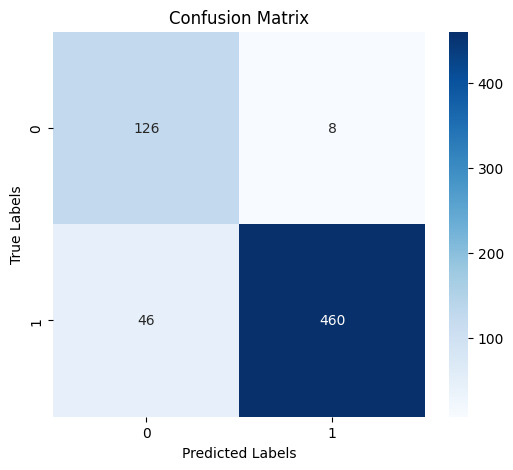

In [ ]:
import torch
import wandb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

# --- Initialize wandb ---
wandb.init(project="Eye_Disease_Pred_b4")

# --- Set model to evaluation mode ---
model.eval()

# --- Initialize trackers ---
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

## --- Test Loop ---
test_loader_tqdm = tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing", ncols=100)

with torch.no_grad():
    for batch_idx, (batch_data) in test_loader_tqdm:  # Modified line to unpack as a single tuple
        images, labels, _ = batch_data  # Modified to correctly unpack
        # OR
        #images, labels = batch_data[0], batch_data[1] #Alternate fix

        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)  # (B, 1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        batch_size = images.size(0)
        test_loss += loss.item() * batch_size

        preds = (torch.sigmoid(outputs) > 0.5)
        correct += (preds == labels.bool()).sum().item()
        total += batch_size

        # Collect predictions for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Batch-wise logging
        batch_acc = (preds == labels.bool()).sum().item() / batch_size
        wandb.log({
            "test/loss_batch": loss.item(),
            "test/accuracy_batch": batch_acc,
        }, step=batch_idx)

        # Update tqdm
        test_loader_tqdm.set_postfix({
            "batch_loss": loss.item(),
            "batch_acc": batch_acc
        })


# --- Final Test Results ---
avg_test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct / total

wandb.log({
    "test/loss_final": avg_test_loss,
    "test/accuracy_final": test_accuracy
})

print(f"\n✅ Test Completed: Avg Loss = {avg_test_loss:.4f}, Accuracy = {test_accuracy:.4f}")

# --- Confusion Matrix Plot ---
cm = confusion_matrix(np.array(all_labels).astype(int), np.array(all_preds).astype(int))

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Log confusion matrix to WandB
wandb.log({"Confusion_Matrix": wandb.Image(fig)})

# Finish WandB Run
wandb.finish()


Precision: 0.9829
Recall: 0.9091
F1 Score: 0.9446
Accuracy: 0.9156


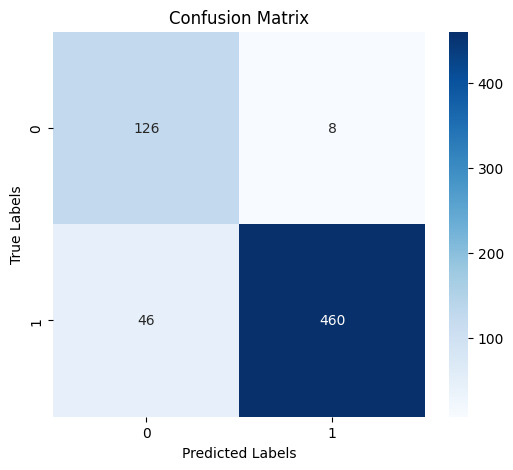

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Calculate Precision, Recall, F1, and Accuracy ---
precision = precision_score(np.array(all_labels).astype(int), np.array(all_preds).astype(int))
recall = recall_score(np.array(all_labels).astype(int), np.array(all_preds).astype(int))
f1 = f1_score(np.array(all_labels).astype(int), np.array(all_preds).astype(int))
accuracy = accuracy_score(np.array(all_labels).astype(int), np.array(all_preds).astype(int))

# --- Print Results ---
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(np.array(all_labels).astype(int), np.array(all_preds).astype(int))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Show Confusion Matrix
plt.show()
